# Overview

- data
- `dask` (http://dask.pydata.org/en/latest)
- `dask.bag`
- `distributed`

# Links
- Matthew Rocklin on `dask` at PyData Berlin 2015 https://www.youtube.com/watch?v=HLME2WKTJJ8
- Matthew Rocklin on `dask` at PyData Seattle 2015 https://www.youtube.com/watch?v=PAGjm4BMKlk
- Blog and examples about `dask` and `dask.distributed` https://www.opendatascience.com/blog/introducing-dask-distributed/

# Packages used in the notebook
You can install all of these with `pip` or `conda`, with the exception of `graphviz` which for some reason I couldn't get to work on `conda`, so use `pip` for that.
- dask
- pandas
- seaborn
- graphviz

In [2]:
import os
import json
import shutil

In [3]:
pth = os.path.join(os.path.expanduser('~/'), 'pydata_hackathon', 'bundestag')
files = [os.path.join(pth, f) for f in os.listdir(pth) if os.path.isfile(os.path.join(pth, f))]

In [6]:
len(files), files[:5]

(412,
 ['/Users/mattilyra/pydata_hackathon/bundestag/17001.json',
  '/Users/mattilyra/pydata_hackathon/bundestag/17002.json',
  '/Users/mattilyra/pydata_hackathon/bundestag/17003.json',
  '/Users/mattilyra/pydata_hackathon/bundestag/17004.json',
  '/Users/mattilyra/pydata_hackathon/bundestag/17005.json'])

In [7]:
with open('../pydata_hackathon/bundestag/17001.json', 'r') as fh:
    data = json.load(fh)

In [8]:
data[10]

{'filename': 'data/txt/17001.txt',
 'in_writing': False,
 'sequence': 159,
 'sitzung': 1,
 'speaker': 'Petra Pau (DIE LINKE)',
 'speaker_cleaned': 'Petra Pau',
 'speaker_fp': 'petra-pau',
 'speaker_party': 'linke',
 'text': 'Ich nehme die Wahl gerne an und freue mich auf die weitere Zusammenarbeit mit allen Kolleginnen und Kollegen.',
 'type': 'speech',
 'wahlperiode': 17}

Instead of doing something silly and loading all the data into memory:

```python
pth = os.path.join(os.path.expanduser('~/'), 'pydata_hackathon', 'bundestag')
files = [os.path.join(pth, f) for f in os.listdir(pth) if os.path.isfile(os.path.join(pth, f))]
documents = []
for f in files:
  with open(f, r) as fh:
    data = json.load(fh)
    documents.extend(data)```

# What to do?
- how much does each party / speaker get to speak
- which words are the most frequent per party / speaker

In [4]:
import dask.bag as db
import json

records = db.read_text('../pydata_hackathon/bundestag/*.json').map(json.loads)

### Each partition will have the computations applied to them in parallel

In [20]:
records.npartitions

412

In [19]:
records.take(1)

([{'filename': 'data/txt/17001.txt',
   'in_writing': False,
   'sequence': 169,
   'sitzung': 1,
   'speaker': None,
   'speaker_cleaned': None,
   'speaker_fp': None,
   'speaker_party': None,
   'text': 'Beifall',
   'type': 'poi',
   'wahlperiode': 17},
  {'filename': 'data/txt/17001.txt',
   'in_writing': False,
   'sequence': 168,
   'sitzung': 1,
   'speaker': 'Präsident Dr. Norbert Lammert',
   'speaker_cleaned': 'Dr. Norbert Lammert',
   'speaker_fp': 'norbert-lammert',
   'speaker_party': None,
   'text': 'im Rahmen eines kleinen Empfangs in der Fraktionsebene Gelegenheit zum Gespräch mit den neu gewählten Mitgliedern des Präsidiums ist.',
   'type': 'chair',
   'wahlperiode': 17},
  {'filename': 'data/txt/17001.txt',
   'in_writing': False,
   'sequence': 167,
   'sitzung': 1,
   'speaker': None,
   'speaker_cleaned': None,
   'speaker_fp': None,
   'speaker_party': None,
   'text': 'Heiterkeit',
   'type': 'poi',
   'wahlperiode': 17},
  {'filename': 'data/txt/17001.txt',
 

### How many distinct speakers?

In [21]:
records.pluck("speaker_cleaned").distinct().compute()

TypeError: list indices must be integers or slices, not str

Traceback
---------
  File "/Users/mattilyra/conda/envs/py35/lib/python3.5/site-packages/dask/async.py", line 263, in execute_task
    result = _execute_task(task, data)
  File "/Users/mattilyra/conda/envs/py35/lib/python3.5/site-packages/dask/async.py", line 245, in _execute_task
    return func(*args2)
  File "/Users/mattilyra/conda/envs/py35/lib/python3.5/site-packages/dask/bag/core.py", line 1630, in empty_safe_apply
    part = list(part)


The `json` files are in the incorrect format, the `dask` documentation for `bag.read_text` says

> Dask.bag can load data directly from textfiles. You can pass either a single filename, a list of filenames, or a globstring. The resulting bag will have one item per line, one file per partition:

The `json` files currently just contain a single list of `json` dictionaries

In [9]:
!head -1 ../pydata_hackathon/bundestag/17001.json

[{"sitzung": 1, "in_writing": false, "sequence": 169, "text": "Beifall", "wahlperiode": 17, "speaker_cleaned": null, "speaker_fp": null, "filename": "data/txt/17001.txt", "speaker": null, "speaker_party": null, "type": "poi"}, {"sitzung": 1, "in_writing": false, "sequence": 168, "text": "im Rahmen eines kleinen Empfangs in der Fraktionsebene Gelegenheit zum Gespr\u00e4ch mit den neu gew\u00e4hlten Mitgliedern des Pr\u00e4sidiums ist.", "wahlperiode": 17, "speaker_cleaned": "Dr. Norbert Lammert", "speaker_fp": "norbert-lammert", "filename": "data/txt/17001.txt", "speaker": "Pr\u00e4sident Dr. Norbert Lammert", "speaker_party": null, "type": "chair"}, {"sitzung": 1, "in_writing": false, "sequence": 167, "text": "Heiterkeit", "wahlperiode": 17, "speaker_cleaned": null, "speaker_fp": null, "filename": "data/txt/17001.txt", "speaker": null, "speaker_party": null, "type": "poi"}, {"sitzung": 1, "in_writing": false, "sequence": 166, "text": "Ich m\u00f6chte alle gew\u00e4hlten Kolleginnen und

In [22]:
!mkdir ../pydata_hackathon/bundestag/unravelled

mkdir: ../pydata_hackathon/bundestag/unravelled: File exists


Transform the `json` files into invalid one dictionary per line `json` 

In [23]:
for f in files:
    if (os.path.isdir(f)):
        continue
    with open(f) as fh, open(os.path.join(pth, "unravelled", os.path.basename(f)), 'w') as fh_out:
        docs = json.load(fh)
        for d in docs:
            s = json.dumps(d, fh_out)
            fh_out.write(s)
            fh_out.write('\n')

### How many distinct speakers are there?

In [5]:
records = db.read_text('../pydata_hackathon/bundestag/unravelled/*.json').map(json.loads)
records.pluck('speaker_cleaned').distinct().count().compute()

3683

In [49]:
import seaborn as sns
import pandas as pd
speaker_freq = records.pluck('speaker_cleaned').frequencies()

In [50]:
speaker_freq.compute()[:5]

[('', 35),
 ('Ich rufe also nunmehr die dringliche Frage 2 der Kollegin Vogler auf', 1),
 ('Dann verfahren wir so und kommen zu Frage 19 des Kollegen Ströbele', 1),
 ('Dr. Lukrezia Jochimsen', 335),
 ('Sören Bartol', 1087)]

There's lots of speakers, but the list also has quite a bit of noise in it.

In [51]:
speakers = (records
           .pluck('speaker_cleaned')
           .filter(lambda speaker: speaker is not None and 0 < len(speaker) < 20))
speaker_freq = speakers.frequencies()

In [52]:
speaker_freq.compute()[:5]

[('Dr. Reinhard Brandl', 606),
 ('Ute Koczy', 288),
 ('Siegfried Kauder', 169),
 ('Sören Bartol', 1087),
 ('Dr. Carola Reimann', 368)]

In [53]:
speaker_freq.topk(10, key=lambda x: x[1]).compute()

[('Dr. Norbert Lammert', 10234),
 ('Petra Pau', 9029),
 ('Eduard Oswald', 5080),
 ('Hubertus Heil', 4131),
 ('Volker Kauder', 4110),
 ('Claudia Roth', 3981),
 ('Gerda Hasselfeldt', 3438),
 ('Ulla Schmidt', 3424),
 ('Elke Ferner', 3310),
 ('Renate Künast', 3212)]

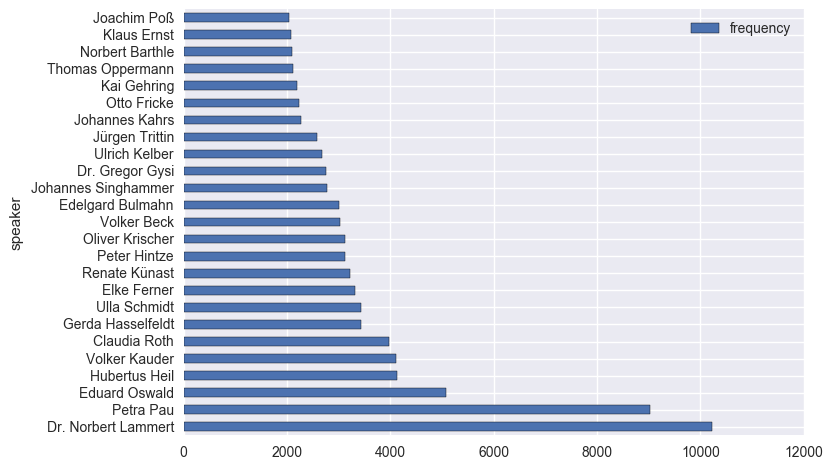

In [55]:
df = (pd.DataFrame(data=speaker_freq.topk(25, lambda x: x[1]).compute(),
                   columns=('speaker', 'frequency'))
      .set_index('speaker'))
_ = df.plot(kind='barh')

In [56]:
df.head()

,frequency
speaker,
Dr. Norbert Lammert,10234
Petra Pau,9029
Eduard Oswald,5080
Hubertus Heil,4131
Volker Kauder,4110


In [56]:
records = db.read_text('../pydata_hackathon/bundestag/unravelled/*.json').map(json.loads)
g = records.pluck('speaker_cleander').distinct()
g.visualize(optimize_graph=False, format='pdf')

[dask graph](mydask.pdf)

----

In [157]:
dask.set_options(get=dask.get)

In [148]:
records = db.read_text('../pydata_hackathon/bundestag/unravelled/*.json').map(json.loads)

In [149]:
fdp_word_usage = (records.filter(lambda d: d['type'] == 'speech')
        .filter(lambda d: d['speaker'] is not None and 0 < len(d['speaker']) < 20)
        .filter(lambda d: d['speaker_party'] is not None and d['speaker_party'] == 'fdp')
        .pluck('text')
        .map(lambda text: text.lower().split())
        .concat()
)

In [158]:
fdp_word_usage.frequencies().topk(10, key=lambda x: x[1]).compute()

[('die', 18870),
 ('der', 15257),
 ('und', 12956),
 ('wir', 9397),
 ('in', 9286),
 ('das', 9162),
 ('sie', 6540),
 ('ist', 6043),
 ('dass', 5979),
 ('den', 5843)]

Unsurprisingly this list is not particularly informative as it is just the most frequent words in the German vocabulary in general.

Let's do average word usage over all documents instead

In [159]:
party = 'fdp'
party_records = (records.filter(lambda d: d['type'] == 'speech')
        .filter(lambda d: d['speaker'] is not None and 0 < len(d['speaker']) < 20)
        .filter(lambda d: d['speaker_party'] is not None and d['speaker_party'] == party))

# going over the party_records twice is pretty inefficient - there probably a way to do this better
party_doc_freq = dict(party_records
        .pluck('text')
        .map(lambda text: set(text.lower().split()))
        .concat()
        .frequencies())

party_word_usage = dict(party_records
        .pluck('text')
        .map(lambda text: text.lower().split())
        .concat()
        .frequencies()
        .map(lambda word, freq: (word, freq / party_doc_freq[word]))
)

In [160]:
sorted(party_word_usage.items(), key=lambda x: x[1], reverse=True)[:20]

[('jugend-', 14.0),
 ('bahai', 10.666666666666666),
 ('beiräte', 10.0),
 ('westsahara', 10.0),
 ('spielerschutz', 9.0),
 ('todesstrafe', 9.0),
 ('unfallkasse', 8.0),
 ('occar', 8.0),
 ('kinderarbeit', 7.25),
 ('japanische', 7.0),
 ('fakultativprotokolls', 7.0),
 ('spielerkarte', 7.0),
 ('ead', 6.5),
 ('mumia', 6.0),
 ('wlan', 6.0),
 ('stade', 6.0),
 ('asbest', 6.0),
 ('roma', 5.785714285714286),
 ('örtlichen', 5.5),
 ('amtshilfe', 5.0)]

In [164]:
party = 'cducsu'
party_records = (records.filter(lambda d: d['type'] == 'speech')
        .filter(lambda d: d['speaker'] is not None and 0 < len(d['speaker']) < 20)
        .filter(lambda d: d['speaker_party'] is not None and d['speaker_party'] == party))

party_doc_freq = dict(party_records
        .pluck('text')
        .map(lambda text: set(text.lower().split()))
        .concat()
        .frequencies())

party_word_usage = dict(party_records
        .pluck('text')
        .map(lambda text: text.lower().split())
        .concat()
        .frequencies()
        .map(lambda word, freq: (word, freq / party_doc_freq[word]))
)

In [165]:
sorted(party_word_usage.items(), key=lambda x: x[1], reverse=True)[:20]

[('polarforschung', 9.5),
 ('awi', 4.0),
 ('die', 3.857142857142857),
 ('arktis', 3.5),
 ('der', 3.25),
 ('und', 3.197674418604651),
 ('finden', 3.0),
 ('erhöhung', 3.0),
 ('\x84globe\x93', 3.0),
 ('arktis-forschung', 3.0),
 ('\x84polarstern\x93', 3.0),
 ('arktischen', 2.5),
 ('bedeutung', 2.5),
 ('internationale', 2.5),
 ('gewalt', 2.5),
 ('für', 2.388888888888889),
 ('das', 2.3484848484848486),
 ('kind', 2.3333333333333335),
 ('in', 2.2705882352941176),
 ('deutsche', 2.25)]

----

`dask.bag` is an `iterable`, which means you can pass it to a `dict` constructor

In [45]:
fdp_freq_words = dict(fdp_word_usage.frequencies())

To get to the actually insightful most frequent words we need to use contextual information about what parties say. This information however is global, which makes things slightly more tricky.

$$
idf(t, D) = \log{\frac{N}{\left\vert\left\{ d \in D : t \in d \right\}\right\vert}}
$$


In [66]:
import math

In [102]:
true_records = records.filter(lambda d: d['type'] == 'speech').filter(lambda d: d['speaker'] is not None and 0 < len(d['speaker']) < 20)
num_docs = true_records.count().compute()
idfs = (true_records
        .pluck('text')
        .map(lambda text: set(text.lower().split()))
        .concat()
        .frequencies()
        .map(lambda word, doc_freq: (word, math.log2(num_docs / doc_freq)))
)

In [122]:
idfs_dict = dict(idfs)

In [124]:
idfs_dict['sicherheit']

5.90601823646768

In [123]:
idfs_dict['der'], idfs_dict['die'], idfs_dict['das']

(0.6907178701464926, 0.5580699050150078, 0.8246141394519536)

In [126]:
fdp_freq_words['der'] * idfs_dict['der']

10538.282544825037

In [116]:
doc_freq = (true_records
        .pluck('text')
        .map(lambda text: set(text.lower().split()))
        .concat()
        .frequencies()
)

In [118]:
docfreq = dict(doc_freq)

In [120]:
num_docs

23146

In [119]:
docfreq['der']

14340

In [106]:
itr = iter(idfs)

In [113]:
fdp_distinctive_words = {k:fdp_freq_words[k] * idf for k,idf in idfs if k in fdp_freq_words}

In [128]:
sorted(fdp_distinctive_words.items(), key=lambda x: x[1], reverse=True)[150:165]

[('beim', 1648.6410131057903),
 ('politik', 1647.5593348132595),
 ('machen', 1647.1900001199226),
 ('sind,', 1635.8470614864502),
 ('bereich', 1633.970372785724),
 ('sollten', 1623.8918427541932),
 ('ihren', 1618.4988221948463),
 ('dank.', 1614.3212994023997),
 ('bereits', 1614.1518485158294),
 ('nämlich', 1612.214277661252),
 ('ihrem', 1593.458710650541),
 ('weg', 1589.0354030482479),
 ('daher', 1586.249019990864),
 ('genau', 1580.5558531955362),
 ('mir', 1558.5503470525243)]

----

As with almost anything there are several ways of achieving the same outcome. Here's an alternative to the above that isn't quite as good.

In [6]:
bag = db.from_sequence([(1, 'the dask bag'),
                        (2, 'b b'),
                        (3, 'c c'),
                        (1, 'is pretty cool'),
                        (4, 'd d'),
                        (1, 'don\'t you think?'),
                        (4, 'I think so')])

In [16]:
def binop(a, b):
    print('binop', a, b)
    return a[0], a[1] + b[1]

In [18]:
def combine(a, b):
    print('combine', a, b)
    return a[0], a[1] + b[1]

In [9]:
import dask
dask.set_options(get=dask.async.get_sync)

In [22]:
bag.map(lambda x: (x[0], x[1].split())).foldby(0, binop=binop, combine=combine).compute()

combine (1, ["don't", 'you', 'think?']) (1, ['the', 'dask', 'bag'])
combine (1, ["don't", 'you', 'think?', 'the', 'dask', 'bag']) (1, ['is', 'pretty', 'cool'])
combine (4, ['d', 'd']) (4, ['I', 'think', 'so'])


[(1,
  (1,
   ["don't", 'you', 'think?', 'the', 'dask', 'bag', 'is', 'pretty', 'cool'])),
 (2, (2, ['b', 'b'])),
 (3, (3, ['c', 'c'])),
 (4, (4, ['d', 'd', 'I', 'think', 'so']))]

-----

# What's nice
- debugging is much easier than for instance `spark`
- `dask.bag` is iterable
- 

# What's annoying
- can't call `.pluck("field_1", "field_2")` (might be able to use `itemgetter`, but I haven't tested it)


# What's difficult

- functional programming
- computations that need global state